# Signal Processing assignment 1


### Spiridon Dragoș


Import libraries

---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Reading the dataset

In [ ]:
df = pd.read_csv("AirQualityUCI.csv", delimiter=";", decimal=",")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


### Preprocessing
Dropping the NMHC(GT) column as suggested and updating the table for missing values (with the average between the previous one and the next one, or if there are more than two consecutively taking the data from the previous day).


In [ ]:
df = df[df["Date"].notna()]
df = df.drop(["NMHC(GT)", "Unnamed: 15", "Unnamed: 16"], axis=1)

In [ ]:
# taking the columns and removing date and time
df_columns = df.columns[2:]

df_mean = df[df_columns].copy()

# if one element is nan and the others between it are not nan
df_mean[(df_mean == -200.0) & (df_mean.shift(-1) != -200.0)  & (df_mean.shift(1) != -200.0)] = (df_mean.shift(-1) + df_mean.shift(1)) / 2

df[df_columns] = df_mean

# if there are several nans in a row, get the same value from the previous day andthe same hour
# it is clearly that we will edit all nans values from now, as the lonely ones were modified before

df_24_hours_value = df[df_columns].copy()
# doesn't work, the values are not taken consecutively
# df_24_hours_value[df_24_hours_value[df_columns] == -200.0] = df_24_hours_value.shift(24)
for col in df:
  for row in df.index:
    if row >= 24 and df[col][row] == -200.0:
      df[col][row]= df[col][row-24]


<ipython-input-4-60def7e6e1da>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row]= df[col][row-24]


## Creating functions:

We calculate the cross-correlation and normalized cross-correlation.

But first, some funtions for printing stuff and extracting data from the results.

In [ ]:
def plot_heatmap(matrix):
  plt.xticks(np.arange(0,12, step=1), df_columns, rotation=90)
  plt.yticks(np.arange(0,12, step=1), df_columns)
  plt.imshow(matrix, cmap='seismic')
  plt.colorbar()
  plt.grid()
  plt.show()

def extract_specific_data_from_cross_correlation(df, start, end, i, j, f_cross_correlation, func):
  return func(np.array(f_cross_correlation(df[i][start:end].to_numpy(), df[j][start:end].to_numpy())))

def extract_and_create_matrix(df, start, end, f_cross_correlation, func):
  return np.array([[extract_specific_data_from_cross_correlation(df, start, end, str(i), str(j), f_cross_correlation, func)
  for i in df_columns] for j in df_columns])

In [ ]:
def normalized_cross_correlation(x1, x2):
  t1 = len(x1)
  # give the range of taus
  taus = [i - t1 for i in range(1, 2 * t1)]
  # calculate the cross-correlation

  phis = [np.sum(x1[max(0, tau) - tau:min(t1 - 1 + tau, t1 - 1) - tau] * x2[max(0, tau):min(t1 - 1 + tau, t1 - 1)]) for tau in taus]
  # phis = [np.sum([x1[i - tau] * x2[i] for i in range(max(0, tau), min(t1 - 1 + tau, t1 - 1))]) for tau in taus]
  # calculate the denominator
  normalizer = np.sqrt((sum(np.power(x1, 2)) * sum(np.power(x2, 2))))
  # apply it on each cross correlation
  normalized_phis = [phi / normalizer for phi in phis]

  return normalized_phis

Verify if it is working properly

10


0.9109593452333629

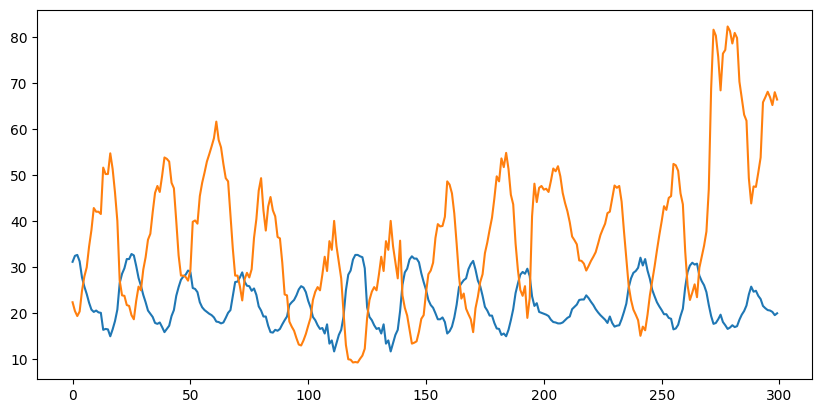

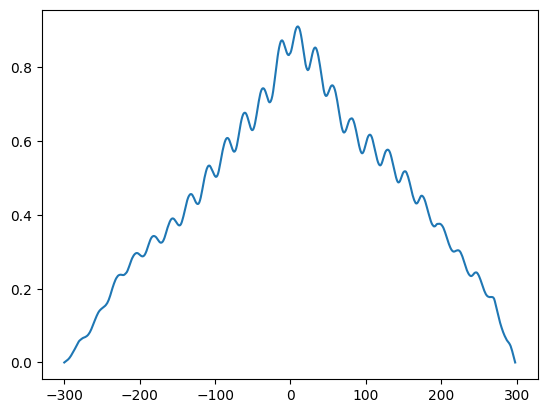

In [ ]:
a, b = 1700, 2000
col1 = "T"
col2 = "RH"
test = np.array(normalized_cross_correlation(df[col1][a:b].to_numpy(), df[col2][a:b].to_numpy()))
assert len(test[(test <= 1) & (test >= -1)]) == len(test)
plt.figure().set_figwidth(10)
plt.plot(df[col1][a:b].to_numpy())
plt.plot(df[col2][a:b].to_numpy())
plt.figure()
plt.plot([i for i in range(-len(test) // 2, len(test) // 2)], test)
maxx = np.argmax(test) - (b - a)
print(maxx)
test[np.argmax(test)]

In the image above, the highest cross-correlation is met when lag is tau=10

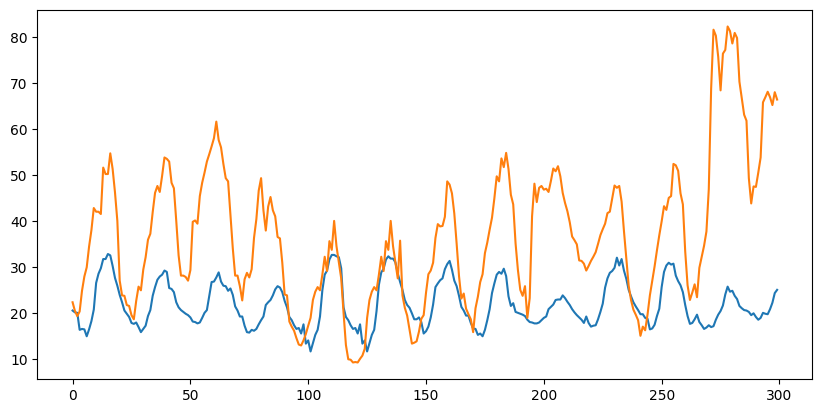

In [ ]:
plt.figure().set_figwidth(10)
plt.plot(df[col1][a + maxx:b + maxx].to_numpy())
plt.plot(df[col2][a:b].to_numpy())

If we move the first signal in time by the highest lag from the cross-correlation results, we observe that they start to have the same alignment.

Now we will apply cross-correlation over all of the columns, and extracting only the maximum value with for a specific tau and maximum value.

The time series on summer (heatmap argmax plot for each tau, heatmap max plot)
Argmax


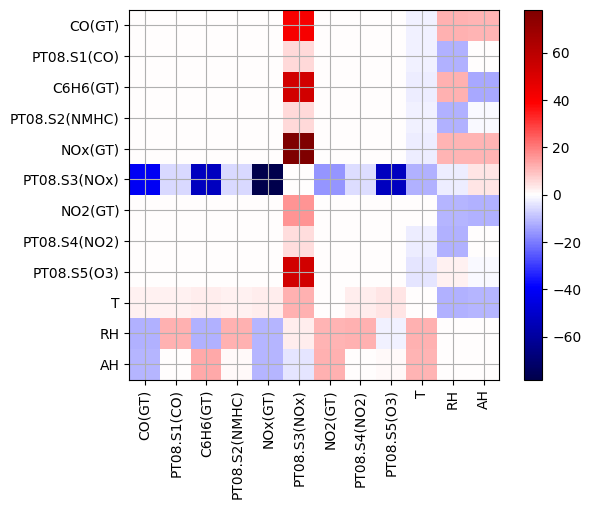

Max


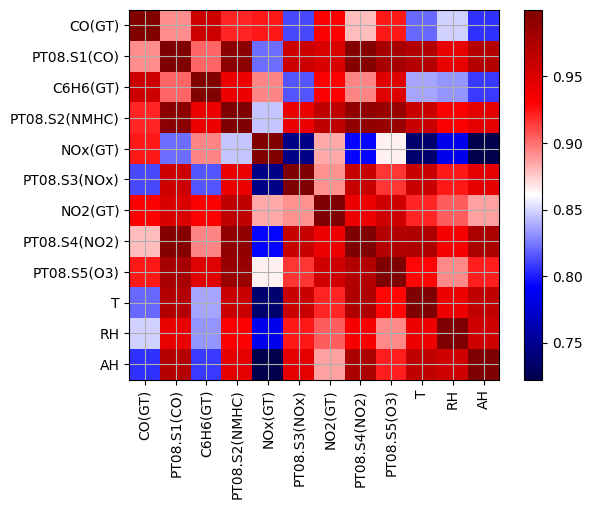

In [ ]:
# we will test it only for summer time (it starts in March)
# which starts at 1st of June (24 * 30 * 3 approx.)
# and ends at 31st of August (24 * 30 * 7 approx.)
start, end = 24 * 30 * 3, 24 * 30 * 7

print("The time series on summer (heatmap argmax plot for each tau, heatmap max plot)")

print("Argmax")
matrix_summer = extract_and_create_matrix(df, start, end, normalized_cross_correlation, np.argmax) - (end - start) + 1

plot_heatmap(matrix_summer)

print("Max")
matrix_summer_max = extract_and_create_matrix(df, start, end, normalized_cross_correlation, np.max)

plot_heatmap(matrix_summer_max)

The entire time series given (the same pattern as above)


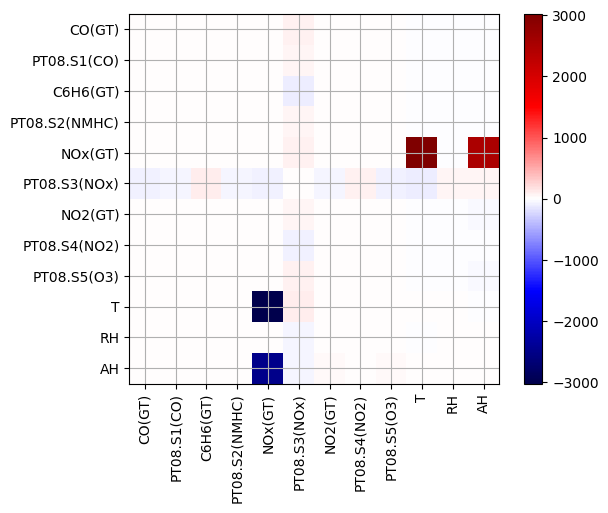

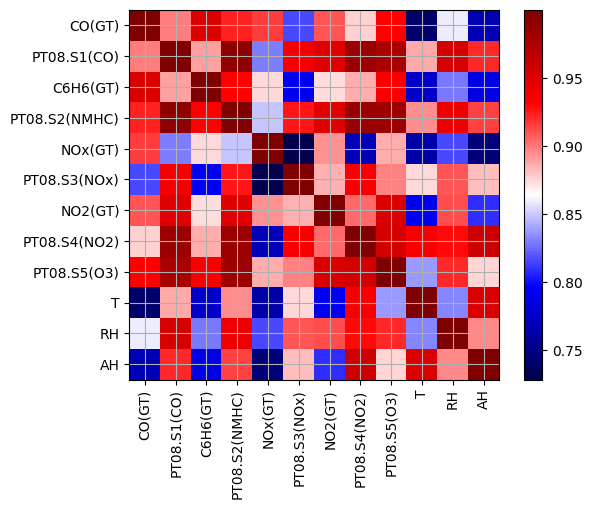

In [ ]:
print("The entire time series given (the same pattern as above)")
start, end = 0, len(df)

matrix_all = extract_and_create_matrix(df, start, end, normalized_cross_correlation, np.argmax) - (end - start) + 1

plot_heatmap(matrix_all)

matrix_all_max = extract_and_create_matrix(df, start, end, normalized_cross_correlation, np.max)

plot_heatmap(matrix_all_max)

In [ ]:
print(matrix_summer[5])
print(matrix_all[5])

[-41  -6 -53  -6 -78   0 -16  -5 -53 -12  -3   4]
[ -87  -64  105  -63  -78    0  -63   80  -78 -107   70   53]


## First interpretation of the results

### Summer experiment

In the first picture, the lag does not go any further than 100, in terms that the range of the summer time series is 24 * 30 * 3 = 2160.

The PT08.S3(NOx) has constantly better similarities with different values rather than 0, which means that

In terms of maximum values, the results in the matrix are symmetric, due to the fact that it does not affect the order of taking the column, it only changes the value of tau. Most of the results are higher than 0.75, which signifies strong correlation between the columns on these experiment.

### All time series experiment

In the second experiment, which can be seen in the third and fourth picture, we took the entire time series. The highest tau changes drastically to 3000, but only on a specific filter (NOx(GT)).

In terms of maximum values, they start to differ a lot from the perspective of smaller confidences, but there is still a high confidence between the sensors (over 750). It results that tau, in some sections, achieves a really good alignment.

### Others

PT08.S3, in both analysises, seems to have a correlation with all of the others in terms of different lags. Even though in the analysis of the third picture, the colour of the color map is barely visible, it is only because there is a higher value and the heatmap colors changes. The values are in the same range as in the first experiment.

Of course, negative values could not have been seen as all the values from the data set are positive, and no negative (except -200 which is changed in the preprocessing step). For a different type of cross-correlation, substracting the mean from each value for calculating the cross-correlation could give different results in these terms.


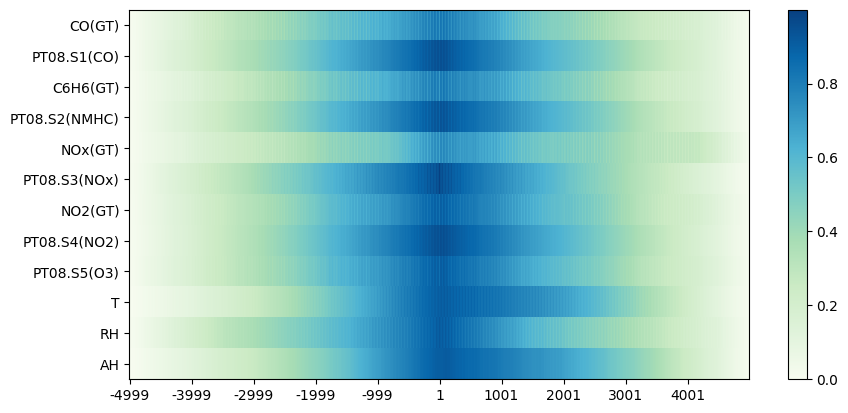

In [ ]:
start, end = 0, 5000
matrix = [normalized_cross_correlation(df["PT08.S3(NOx)"][start:end].to_numpy(), df[j][start:end].to_numpy()) for j in df_columns]

plt.figure().set_figwidth(10)
plt.xticks([i for i in range(0, len(matrix[0]), 1000)], [str(i) for i in range(- (end - start) + 1, end - start, 1000)])
plt.yticks(np.arange(0,12, step=1), df_columns)
plt.imshow(matrix, cmap='GnBu', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

Plotting the cross-correlation for each tau, to see that none of the negative values are touched, and it seems to be increasing with a small frequency, and after reaching the highest point decreasing in a approximately similar way.

## Cross-correlation with mean substracted

We will implement the cross-correlation with the mean substracted for having a different perspective. As in the dataset there aer not data with negative values, we will try to put all of the graphs near 0, and see how it afects the the results. Formula and idea found here: https://paulbourke.net/miscellaneous/correlate/

In [ ]:
def normalized_cross_correlation_mean(x1, x2):
  mean_x1 = sum(x1) / len(x1)
  mean_x2 = sum(x2) / len(x2)
  t1 = len(x1)
  # give the range of taus
  taus = [i - t1 for i in range(1, 2 * t1)]
  # calculate the cross-correlation

  phis = [np.sum((x1[max(0, tau) - tau:min(t1 - 1 + tau, t1 - 1) - tau] - mean_x1)
  * (x2[max(0, tau):min(t1 - 1 + tau, t1 - 1)] - mean_x2)) for tau in taus]
  # phis = [np.sum([x1[i - tau] * x2[i] for i in range(max(0, tau), min(t1 - 1 + tau, t1 - 1))]) for tau in taus]

  # calculate the denominator
  normalizer = np.sqrt((sum(np.power(x1 - mean_x1, 2)) * sum(np.power(x2 - mean_x2, 2))))
  # apply it on each cross correlation
  normalized_phis = [phi / normalizer for phi in phis]

  return normalized_phis

Maximum value index 35 -35 with value 0.5700218632015791
Maximum value index 0 with value -0.6382807071365661


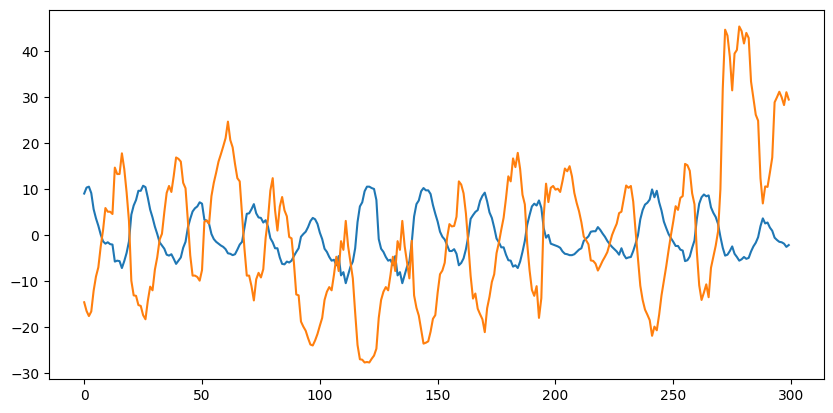

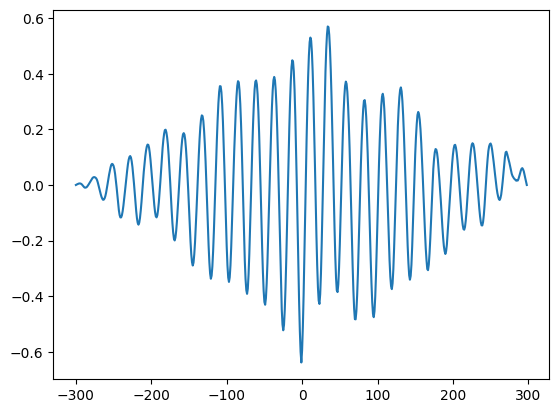

In [ ]:
a, b = 1700, 2000
col1 = "T"
col2 = "RH"
x1 = df[col1][a:b].to_numpy()
x2 = df[col2][a:b].to_numpy()
test_mean = np.array(normalized_cross_correlation_mean(x1, x2))
test_mean_2 = np.array(normalized_cross_correlation_mean(x2, x1))
mean_x1 = sum(x1) / len(x1)
mean_x2 = sum(x2) / len(x2)
plt.figure().set_figwidth(10)
plt.plot(x1 - mean_x1)
plt.plot(x2 - mean_x2)
plt.figure()
plt.plot([i for i in range(-len(test_mean) // 2, len(test_mean) // 2)], test_mean)
maxx_mean = np.argmax(test_mean) - (b - a) + 1
print("Maximum value index", maxx_mean, np.argmax(test_mean_2) - (b - a) + 1, "with value", test_mean[np.argmax(test_mean)])

minn_mean = np.argmin(test_mean) - (b - a) + 1
print("Maximum value index", minn_mean, "with value", test_mean[np.argmin(test_mean)])

In this case, the minimum value is close to 0, which makes sense because, if we look at the first picture with both of the time series, they are closely to be opposite.

Now we will try the same experiment with the first implementation of cross-correlation: moving the sign by the lag tau.

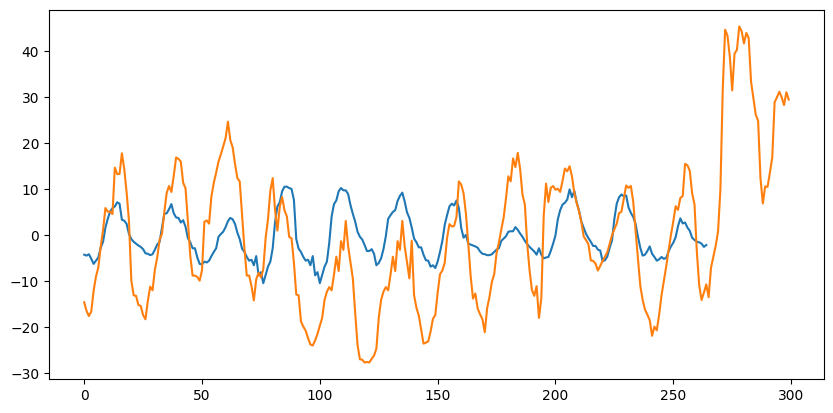

In [ ]:
plt.figure().set_figwidth(10)
plt.plot(df[col1][a + maxx_mean:b].to_numpy() - mean_x1)
plt.plot(x2 - mean_x2)

Another case where the minimum index for tau is not close to 0 (to see if they are simmetrics in terms of Ox)

Maximum value index -1 with value 0.8639170436874278
Minimum value index 77 with value -0.2342904785524092


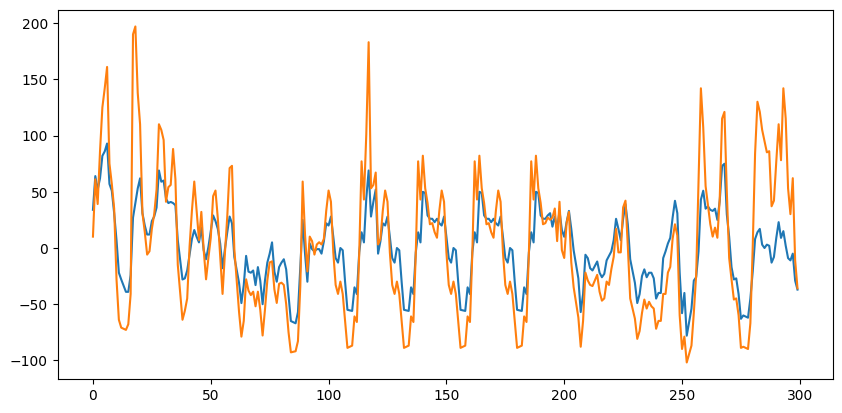

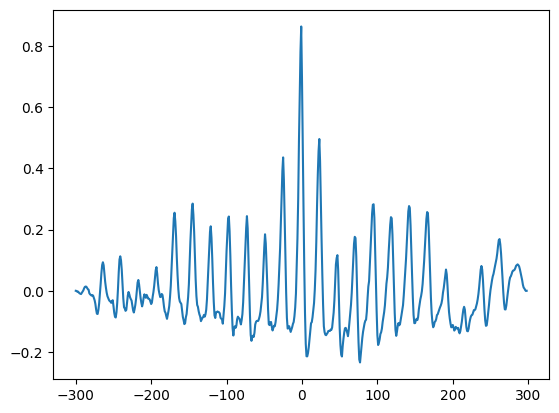

In [ ]:
a, b = 1700, 2000
col1 = "NO2(GT)"
col2 = "NOx(GT)"
x1 = df[col1][a:b].to_numpy()
x2 = df[col2][a:b].to_numpy()
test_mean = np.array(normalized_cross_correlation_mean(x1, x2))
mean_x1 = sum(x1) / len(x1)
mean_x2 = sum(x2) / len(x2)
plt.figure().set_figwidth(10)
plt.plot(x1 - mean_x1)
plt.plot(x2 - mean_x2)
plt.figure()
plt.plot([i for i in range(-len(test_mean) // 2, len(test_mean) // 2)], test_mean)
maxx_mean = np.argmax(test_mean) - (b - a)
print("Maximum value index", maxx_mean, "with value", test_mean[np.argmax(test_mean)])

minn_mean = np.argmin(test_mean) - (b - a)
print("Minimum value index", minn_mean, "with value", test_mean[np.argmin(test_mean)])

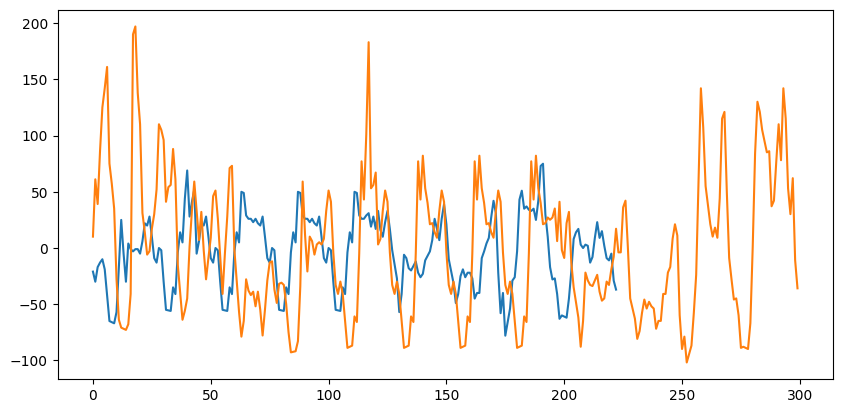

In [ ]:
plt.figure().set_figwidth(10)
plt.plot(df[col1][a + minn_mean:b].to_numpy() - mean_x1)
plt.plot(x2 - mean_x2)

There is a really small minimum, so those two time series with that tau represents that they have nothing in common from the perspective of alignment with that specific lag.


Printing the max tau and maximum cross-correlation level matrices, and also the min tau and minimum cross-correlation level matrices

The time series only on summer - argmax and max


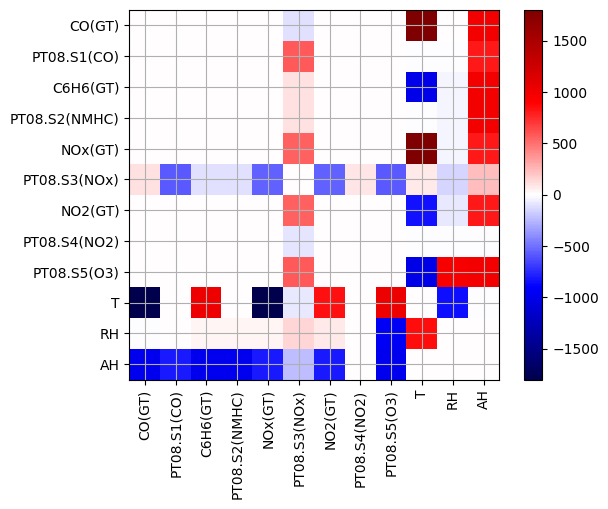

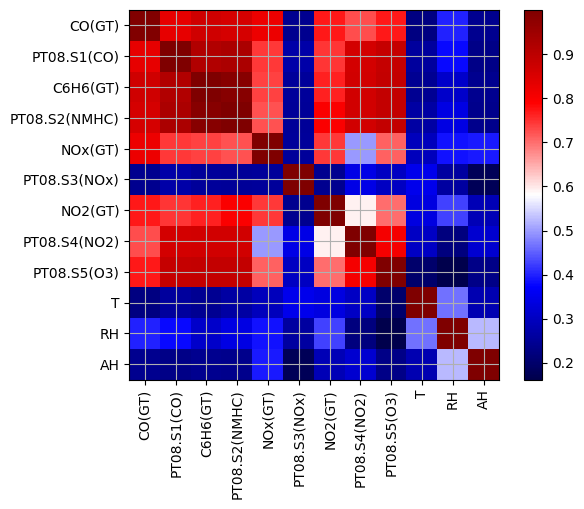

In [ ]:
# still summer time
print("The time series only on summer - argmax and max")
start, end = 24 * 30 * 3, 24 * 30 * 7

matrix_summer_mean = extract_and_create_matrix(df, start, end, normalized_cross_correlation_mean, np.argmax) - (end - start) + 1

plot_heatmap(matrix_summer_mean)

matrix_summer_mean_max = extract_and_create_matrix(df, start, end, normalized_cross_correlation_mean, np.max)

plot_heatmap(matrix_summer_mean_max)

The entire time series - argmax and max


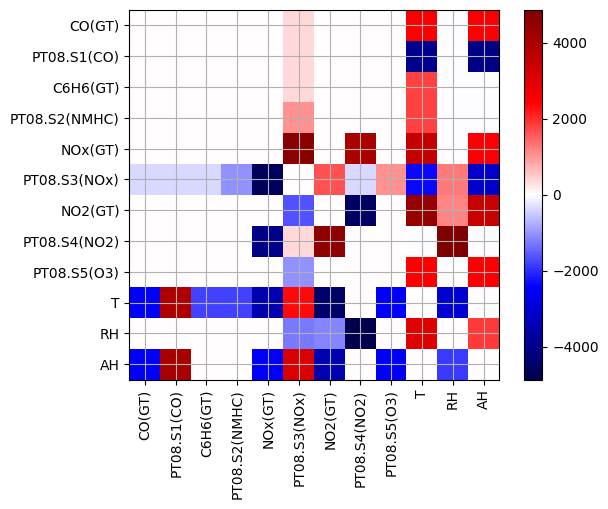

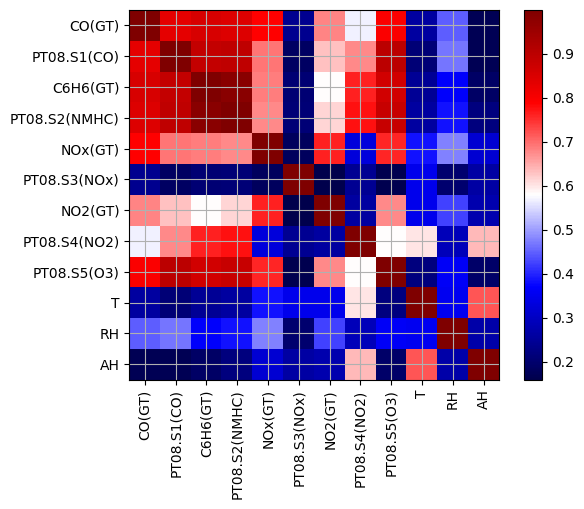

In [ ]:
# all year
print("The entire time series - argmax and max")
start, end = 0, len(df)

matrix_all_mean = extract_and_create_matrix(df, start, end, normalized_cross_correlation_mean, np.argmax) - (end - start) + 1

plot_heatmap(matrix_all_mean)

matrix_all_mean_max = extract_and_create_matrix(df, start, end, normalized_cross_correlation_mean, np.max)

plot_heatmap(matrix_all_mean_max)

In the case of this cross-correlation matrix, we can also observe how the minimum reacts to these two types: summer and all of the time series.

Summer time series - argmin and min


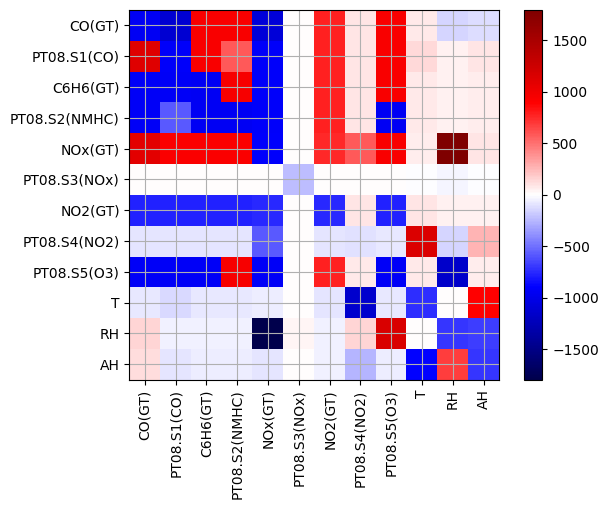

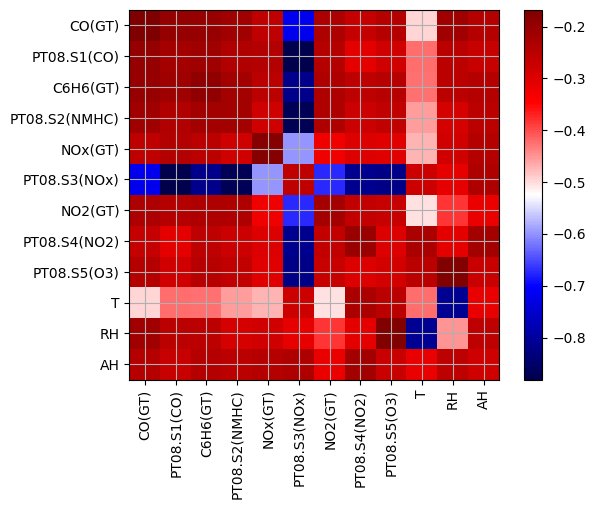

In [ ]:
# summer time
print("Summer time series - argmin and min")
start, end = 24 * 30 * 3, 24 * 30 * 7

matrix_summer_mean = np.array(extract_and_create_matrix(df, start, end, normalized_cross_correlation_mean, np.argmin)) - (end - start) + 1

plot_heatmap(matrix_summer_mean)

matrix_summer_mean_min = extract_and_create_matrix(df, start, end, normalized_cross_correlation_mean, np.min)

plot_heatmap(matrix_summer_mean_min)

All of the time series - argmin and min


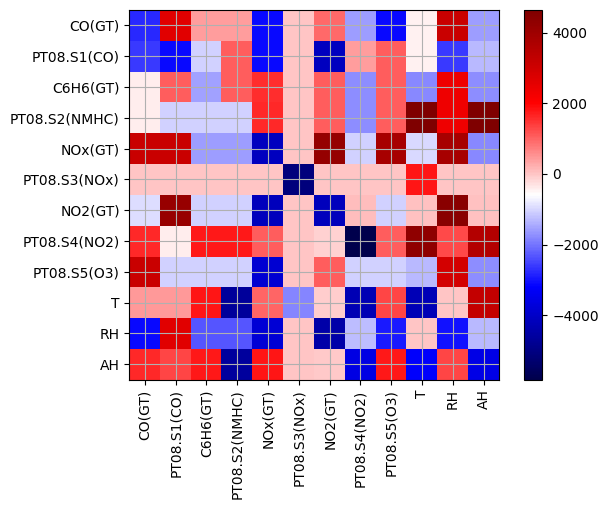

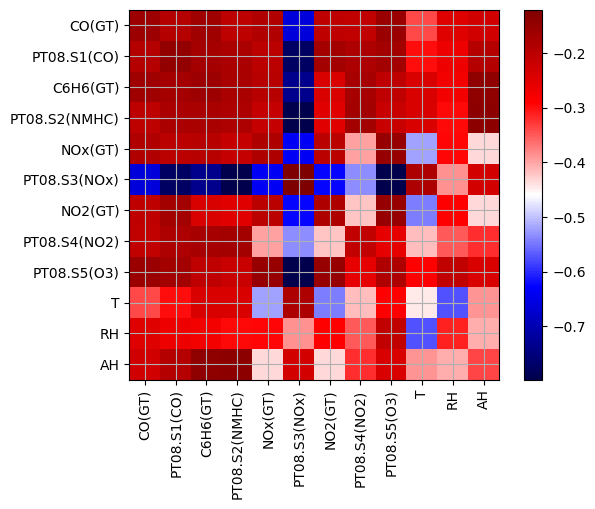

In [ ]:

print("All of the time series - argmin and min")
# all year
start, end = 0, len(df)

matrix_all_mean = np.array(extract_and_create_matrix(df, start, end, normalized_cross_correlation_mean, np.argmin)) - (end - start) + 1

plot_heatmap(matrix_all_mean)

matrix_all_mean_min = extract_and_create_matrix(df, start, end, normalized_cross_correlation_mean, np.min)

plot_heatmap(matrix_all_mean_min)

The extraction of the mean affects the cross-correlation, by finding cross-correlations with higher/ lower lags. Also, for the full time analysis, the similarity the maximum similarity at 0 decreases a lot (it makes sense because now there more values of 0 than before).

With the cross-correlation with the mean substracted, they also tell the opposite alignment depending on a specific lag. PT08.S3 seems to have really low points (maximum is between 0.3 and 0.4 from the graphs with summer/ all time series (we did not count the cross-correlation with itself, because that is autocorrelation, and we are not interested in that)), but it also finds high negative cross-correlation, which means they have opposite signs. For the first features (CO(GT), PT08.S1(CO), C6H6(GT), PT08.S2(NMHC), NOx(GT)), they seem to have strong cross-correlation in both experiments (summer and all year) higher than 0.7. Nevertheless,  


As PT08.S3(NOx) seems to have an interesting alignment with the other features, we will provide the movement o tau for each feature from the perspective of PT08.S3(NOx).

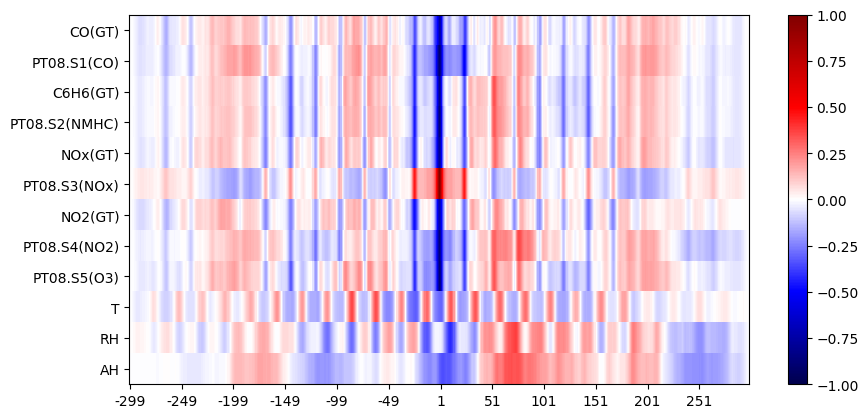

In [ ]:
start, end = 1700, 2000
matrix = [normalized_cross_correlation_mean(df["PT08.S3(NOx)"][start:end].to_numpy(), df[j][start:end].to_numpy()) for j in df_columns]

plt.figure().set_figwidth(10)
plt.xticks([i for i in range(0, len(matrix[0]), 50)], [str(i) for i in range(- (end - start) + 1, end - start, 50)])
plt.yticks(np.arange(0,12, step=1), df_columns)
plt.imshow(matrix, cmap='seismic', interpolation='nearest', aspect='auto', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

By the moves of each value of cross-correlation, and assuming that the color white represents 0 correlation, the frequency is really high in most of them (as it varies between all the colors of seismic (above 0 and lower than 0)), and there are multiple points which tells that there exists a correlation, but still very weak. From the other perspective, the other cases with extreme values are having a strong opposite correlation, which can be seen with the dark blue color, and also all of the other features (except of itself) are meeting with this negative value close to -1.

## Personal considerations

1. It took one hour to find that mask for preprocessing ;-;
2. It was harder to understand the principles of the cross-correlation rather than actually coding it. Also the direction of what should I exactly evaluate.
3. Really hard to analyze the cross-correlation over a high time series, due to a really large tau.
4. I found interesting that you can have an idea on how to "predict" the frequency of another sensor through the cross-correlation result. The idea of alignment works as it could have been observed before.
5. At first, it was not clear why there were no values between -1 and 0 for cross-correlation, but in the dataset there are no negative values, so it make sense if the formula does not take into the consideration.
6. I consider that substracting the mean is a real good improvement, maybe for enhancing the algorithm we could apply also a division by the standard deviation (which would result a complete normalization). I am not sure though if it would damage the cross-correlation result.
7. For next experiments, I should really subplot the results, as I am scrolling too much for analysing the results.